In [ ]:
# from google.colab import drive; drive.mount('/content/drive')
# %cd /content/drive/MyDrive/dev/projects/project1/pill-detect-ai
# import configs.config_paths as cc

Mounted at /content/drive
/content/drive/MyDrive/dev/projects/project1/pill-detect-ai


🔍 JSON 파일 분석 중: 100%|██████████| 4526/4526 [00:12<00:00, 365.75it/s]


📊 전체 이미지 수: 1489
📦 전체 어노테이션 수: 4526
🧠 고유 클래스 수: 73
💊 고유 약 이름 수: 59


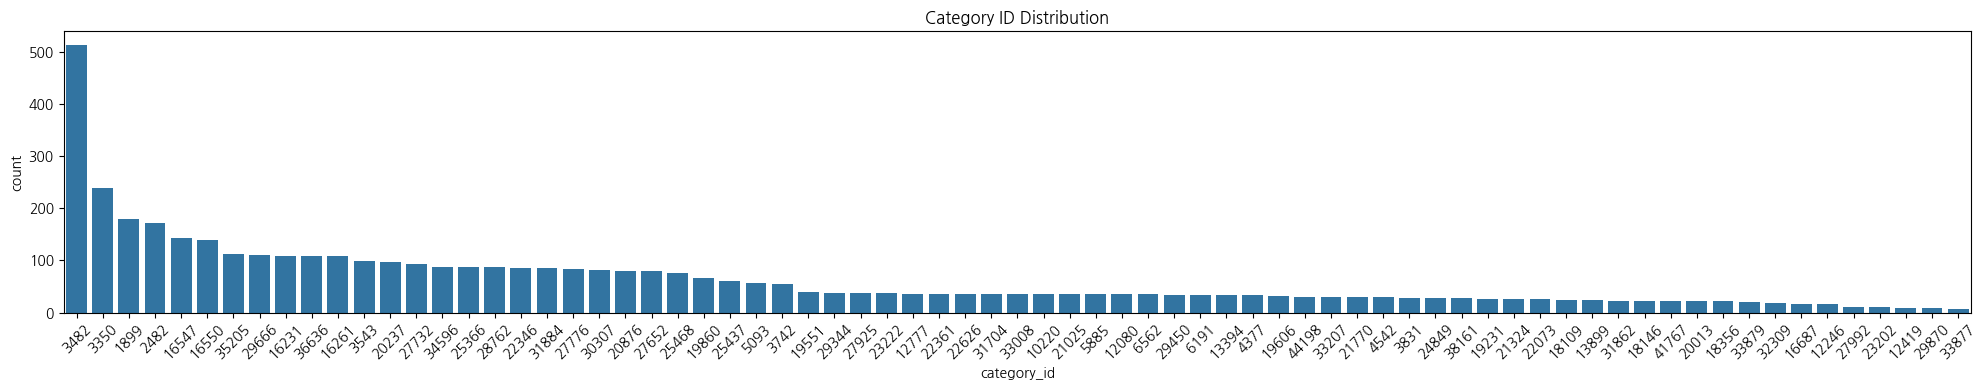

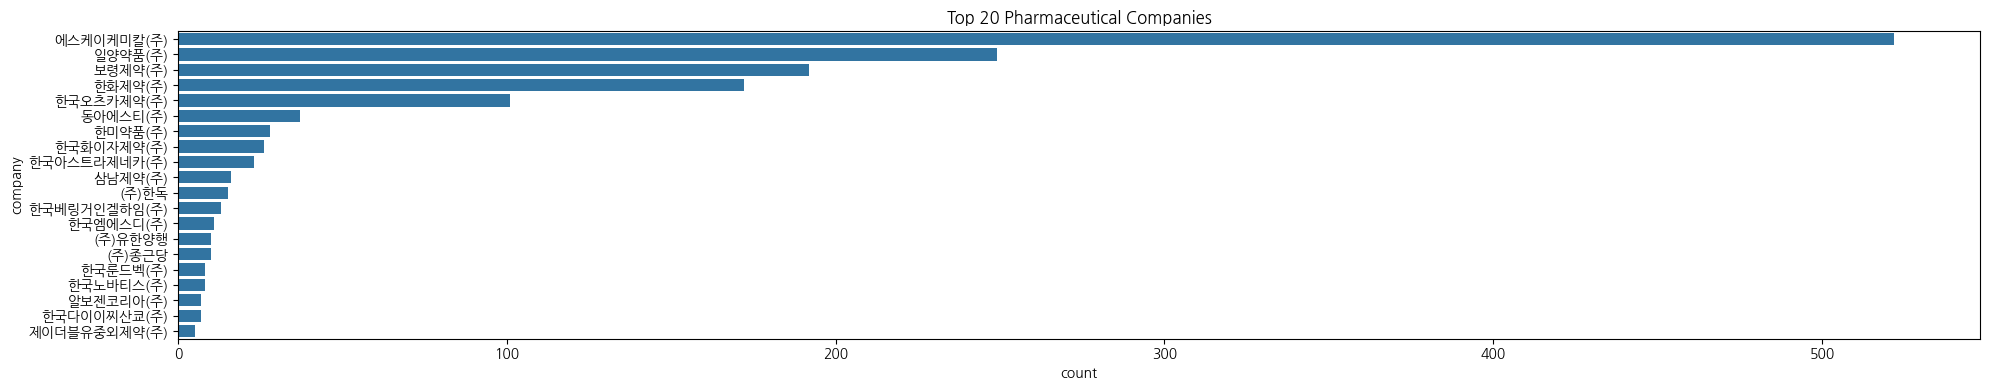

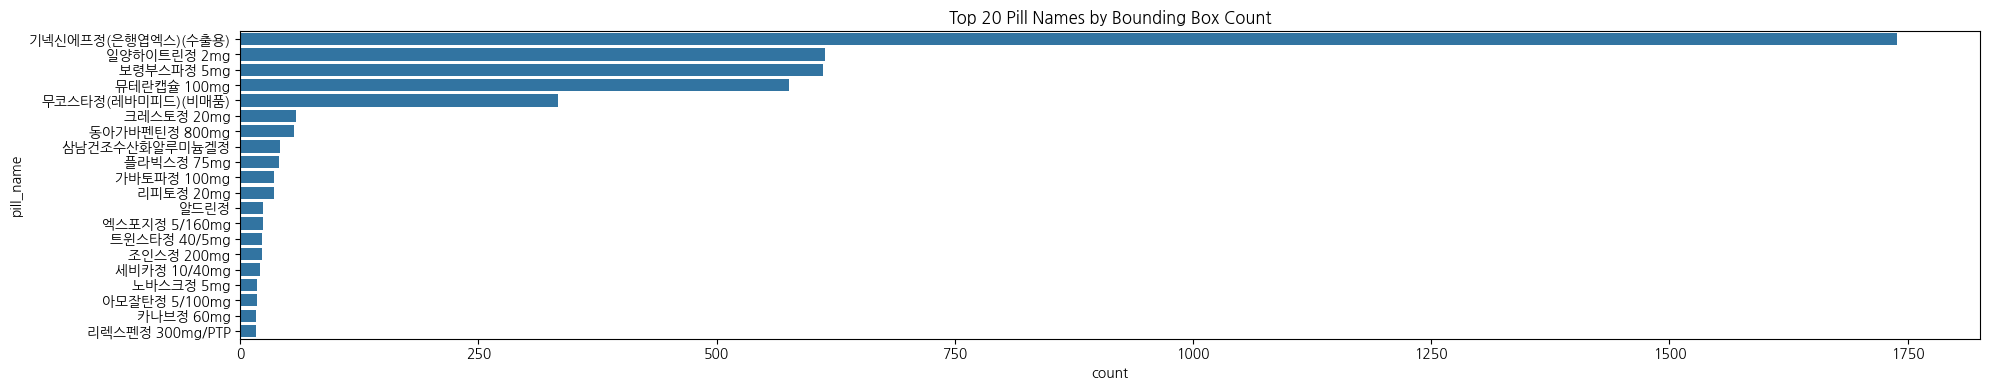

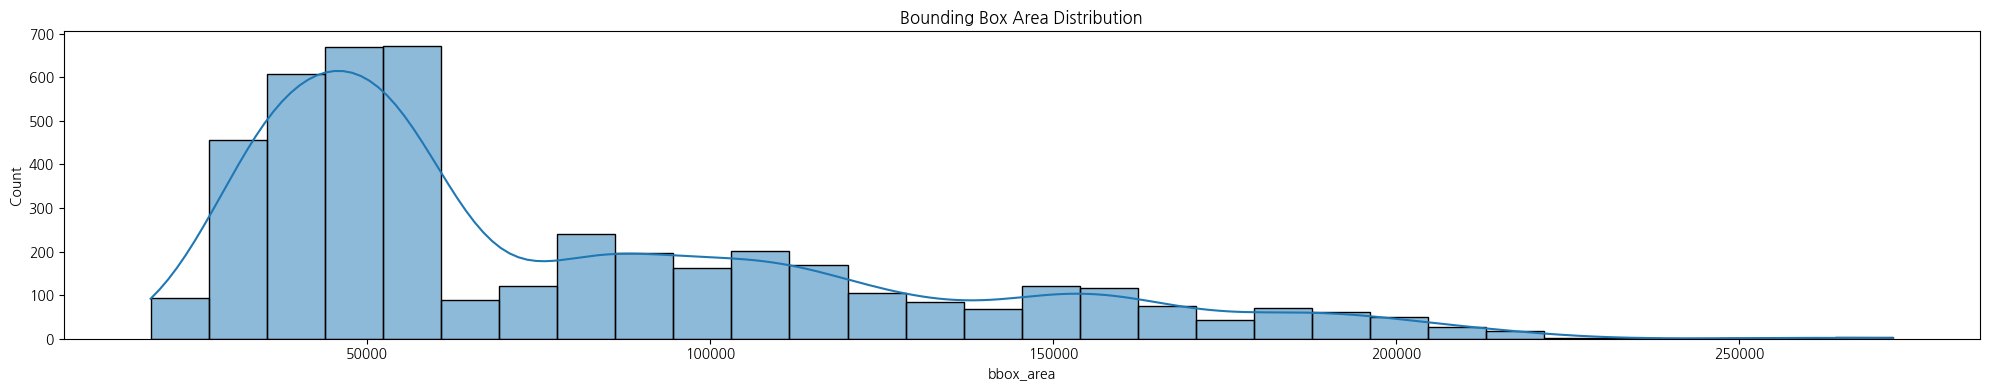

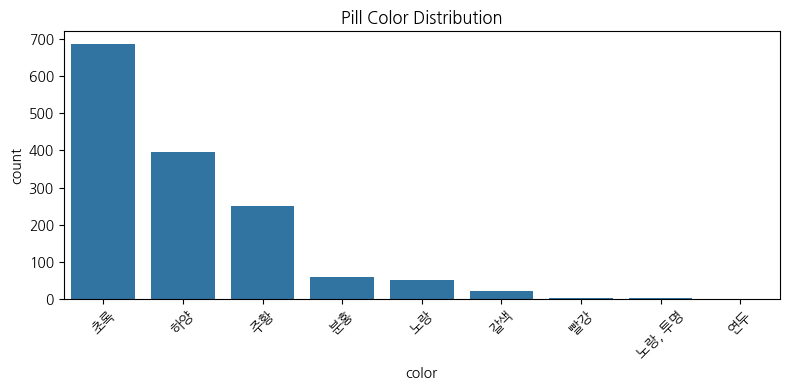

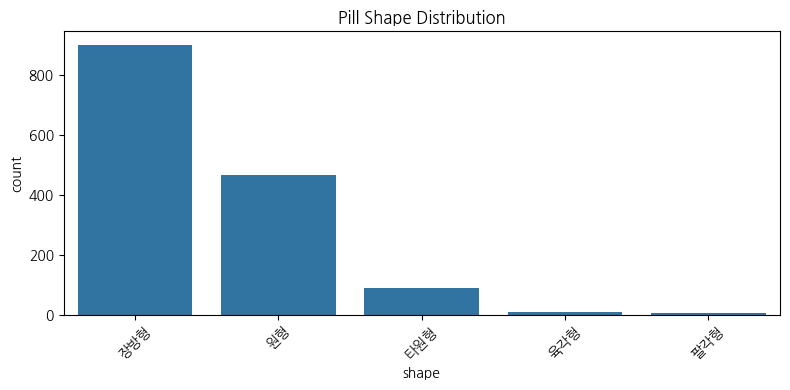

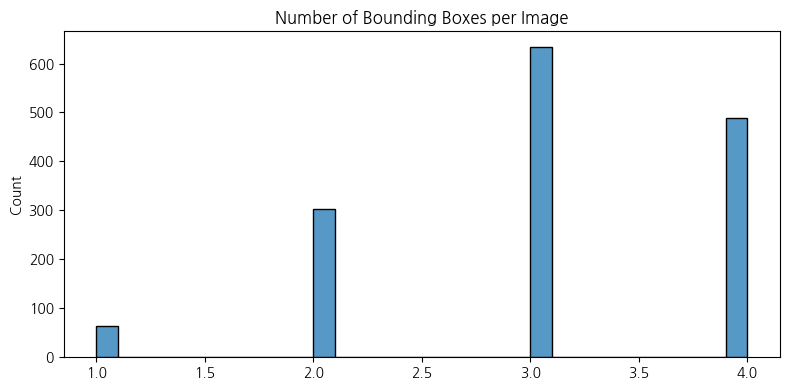

In [6]:
# -------------------- 1. 경로 설정 --------------------
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

LABEL_DIR = 'data/yolo/train_annotations'
json_paths = glob.glob(os.path.join(LABEL_DIR, '*_json', '*', '*.json'))

# -------------------- 2. 데이터 수집 --------------------
meta_records = []
ann_records = []

for path in tqdm(json_paths, desc="🔍 JSON 파일 분석 중"):
    try:
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        if 'images' not in data or not data['images']:
            continue
        img = data['images'][0]
        img_name = img.get('file_name', 'unknown.png')

        # 어노테이션 수집
        for ann in data.get('annotations', []):
            bbox = ann.get('bbox', [])
            if len(bbox) != 4:
                continue
            ann_records.append({
                'image': img_name,
                'category_id': ann.get('category_id', -1),
                'bbox': bbox,
                'area': ann.get('area', 0)
            })

        # 메타정보 수집
        meta_records.append({
            'image': img_name,
            'pill_name': img.get('dl_name', ''),
            'pill_name_en': img.get('dl_name_en', ''),
            'company': img.get('dl_company', ''),
            'material': img.get('dl_material', ''),
            'color': img.get('color_class1', ''),
            'shape': img.get('drug_shape', ''),
            'print_code': f"{img.get('print_front', '')}/{img.get('print_back', '')}",
            'size_mm': f"{img.get('leng_long', '')}x{img.get('leng_short', '')}",
            'category_id': data['annotations'][0]['category_id'] if data['annotations'] else None
        })

    except Exception as e:
        print(f"❌ Error reading {path}\n{e}")

# -------------------- 3. DataFrame 구성 --------------------
ann_df = pd.DataFrame(ann_records)
meta_df = pd.DataFrame(meta_records).drop_duplicates(subset='image')

if len(ann_df) == 0:
    raise ValueError("❌ ann_df is empty. bbox 데이터가 존재하지 않습니다.")

ann_df['bbox_w'] = ann_df['bbox'].apply(lambda b: b[2])
ann_df['bbox_h'] = ann_df['bbox'].apply(lambda b: b[3])
ann_df['bbox_area'] = ann_df['bbox_w'] * ann_df['bbox_h']

merged = pd.merge(ann_df, meta_df, on='image', how='left')

# -------------------- 4. 기본 통계 --------------------
print("📊 전체 이미지 수:", meta_df['image'].nunique())
print("📦 전체 어노테이션 수:", len(ann_df))
print("🧠 고유 클래스 수:", ann_df['category_id'].nunique())
print("💊 고유 약 이름 수:", meta_df['pill_name'].nunique())

# -------------------- 5. 시각화 --------------------
plt.figure(figsize=(20, 4))
sns.countplot(x='category_id', data=ann_df, order=ann_df['category_id'].value_counts().index[:])
plt.title('Category ID Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 4))
sns.countplot(y='company', data=meta_df, order=meta_df['company'].value_counts().index[:20])
plt.title('Top 20 Pharmaceutical Companies')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 4))
sns.countplot(y='pill_name', data=merged, order=merged['pill_name'].value_counts().index[:20])
plt.title('Top 20 Pill Names by Bounding Box Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 4))
sns.histplot(merged['bbox_area'], bins=30, kde=True)
plt.title('Bounding Box Area Distribution')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x='color', data=meta_df, order=meta_df['color'].value_counts().index)
plt.title('Pill Color Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x='shape', data=meta_df, order=meta_df['shape'].value_counts().index)
plt.title('Pill Shape Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

box_per_image = merged.groupby('image').size()
plt.figure(figsize=(8, 4))
sns.histplot(box_per_image, bins=30)
plt.title('Number of Bounding Boxes per Image')
plt.tight_layout()
plt.show()
